In [1]:
import os

import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt

# load data

In [2]:
train_df = pd.read_csv('data/train.csv')
print(train_df.shape)
train_df.head()

(84406, 20)


,ID,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,TARGET
0,TRAIN_00000,9,화요일,10,137,8.0,2.611124,0.000,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2
1,TRAIN_00001,11,화요일,6,438,13.0,3.209093,0.000,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0
2,TRAIN_00002,8,일요일,6,1729,47.0,1.619597,0.000,0.0,0.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,인도,1
3,TRAIN_00003,5,월요일,6,2337,53.0,1.921615,11.375,0.0,0.0,225.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,주거지,1
4,TRAIN_00004,9,일요일,11,1439,41.0,1.789721,0.000,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,주유소,2


In [3]:
test_df = pd.read_csv('data/test.csv')
print(test_df.shape)
test_df.head()

(17289, 19)


,ID,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지
0,TEST_00000,9,금요일,5,927,28.0,1.570654,19.625000,0.0,0.0,165.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,차도
1,TEST_00001,5,수요일,3,926,28.0,1.712457,21.444444,0.0,0.0,175.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,식당
2,TEST_00002,5,월요일,6,1437,33.0,0.447496,25.200000,0.0,0.0,290.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,주거지
3,TEST_00003,11,화요일,1,1739,31.0,0.878585,0.000000,0.0,0.0,285.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,주거지
4,TEST_00004,10,목요일,10,830,15.0,0.496423,26.142857,0.0,0.0,95.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,주거지


# feature exploration

In [4]:
train_df.TARGET.value_counts()

TARGET
0    36453
1    25397
2    22556
Name: count, dtype: int64

# preprocess data

In [5]:
cat_cols = []
num_cols = []

for col in test_df.columns[1:]:
    if train_df[col].dtype == 'object':
        cat_cols.append(col)
    else:
        num_cols.append(col)

print('categorical columns: ', cat_cols)
print('numeric columns: ', num_cols)

categorical columns:  ['요일', '범죄발생지']
numeric columns:  ['월', '시간', '소관경찰서', '소관지역', '사건발생거리', '강수량(mm)', '강설량(mm)', '적설량(cm)', '풍향', '안개', '짙은안개', '번개', '진눈깨비', '서리', '연기/연무', '눈날림']


## preprocess cat data

In [6]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [7]:
train_cat_array = encoder.fit_transform(train_df[cat_cols])
test_cat_array = encoder.transform(test_df[cat_cols])

encoded_cols = np.concatenate(encoder.categories_)
encoded_cols

array(['금요일', '목요일', '수요일', '월요일', '일요일', '토요일', '화요일', '공원', '백화점', '병원',
       '식당', '약국', '은행', '인도', '주거지', '주유소', '주차장', '차도', '편의점', '학교',
       '호텔/모텔'], dtype=object)

In [8]:
train_df = pd.concat([
    train_df.drop(columns=cat_cols),
    pd.DataFrame(train_cat_array, columns=encoded_cols)], axis=1)
    
test_df = pd.concat([
    test_df.drop(columns=cat_cols),
    pd.DataFrame(test_cat_array, columns=encoded_cols)], axis=1)

train_df.shape, test_df.shape

((84406, 39), (17289, 38))

## preprocess numeric data

In [9]:
train_df[num_cols].describe()

,월,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림
count,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000
mean,6.430195,6.769507,1060.027581,26.881726,1.912424,24.608776,2.284407,23.430503,186.926107,0.385423,0.017842,0.144042,0.020330,0.010260,0.210755,0.008921
std,3.108302,3.566390,698.380485,13.870968,0.958556,62.711211,15.852881,85.199896,98.299485,0.486698,0.132379,0.351134,0.141128,0.100771,0.407847,0.094030
min,1.000000,1.000000,26.000000,5.000000,0.012269,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,4.000000,526.000000,13.000000,1.209985,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,7.000000,937.000000,27.000000,1.822279,0.625000,0.000000,0.000000,205.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,10.000000,1638.000000,38.000000,2.476528,18.571429,0.000000,0.000000,260.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,12.000000,2450.000000,54.000000,4.998936,614.875000,295.000000,649.800000,360.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [11]:
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

train_df[num_cols].describe()

,월,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림
count,8.440600e+04,8.440600e+04,8.440600e+04,8.440600e+04,8.440600e+04,8.440600e+04,8.440600e+04,8.440600e+04,8.440600e+04,8.440600e+04,8.440600e+04,8.440600e+04,8.440600e+04,8.440600e+04,8.440600e+04,8.440600e+04
mean,1.522002e-16,1.146132e-16,3.703988e-17,7.176477e-17,2.200506e-16,7.660520e-18,-1.043851e-17,4.322722e-17,5.219256e-17,-3.493534e-18,-4.444785e-17,1.056794e-16,-4.284841e-17,7.500576e-17,-1.052269e-17,-6.759778e-17
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-1.747008e+00,-1.617754e+00,-1.480617e+00,-1.577529e+00,-1.982320e+00,-3.924166e-01,-1.441013e-01,-2.750079e-01,-1.799879e+00,-7.919185e-01,-1.347830e-01,-4.102213e-01,-1.440563e-01,-1.018150e-01,-5.167533e-01,-9.487608e-02
25%,-7.818446e-01,-7.765621e-01,-7.646702e-01,-1.000782e+00,-7.328137e-01,-3.924166e-01,-1.441013e-01,-2.750079e-01,-9.351692e-01,-7.919185e-01,-1.347830e-01,-4.102213e-01,-1.440563e-01,-1.018150e-01,-5.167533e-01,-9.487608e-02
50%,1.833184e-01,6.462963e-02,-1.761623e-01,8.526751e-03,-9.404287e-02,-3.824502e-01,-1.441013e-01,-2.750079e-01,1.838667e-01,-7.919185e-01,-1.347830e-01,-4.102213e-01,-1.440563e-01,-1.018150e-01,-5.167533e-01,-9.487608e-02
75%,8.267604e-01,9.058214e-01,8.275945e-01,8.015547e-01,5.884964e-01,-9.627278e-02,-1.441013e-01,-2.750079e-01,7.433846e-01,1.262756e+00,-1.347830e-01,-4.102213e-01,-1.440563e-01,-1.018150e-01,-5.167533e-01,-9.487608e-02
max,1.791923e+00,1.466616e+00,1.990291e+00,1.955050e+00,3.219977e+00,9.412507e+00,1.846461e+01,7.351807e+00,1.760690e+00,1.262756e+00,7.419332e+00,2.437709e+00,6.941732e+00,9.821737e+00,1.935160e+00,1.054006e+01


In [12]:
train_X = train_df[np.concatenate([encoded_cols, num_cols])]
test_X = test_df[np.concatenate([encoded_cols, num_cols])]
train_X.shape, test_X.shape

((84406, 37), (17289, 37))

In [13]:
train_y = train_df['TARGET']
train_y_multi = pd.get_dummies(train_df['TARGET'])
train_y.shape, train_y_multi.shape

((84406,), (84406, 3))

# Oversampling

In [14]:
from imblearn.over_sampling import RandomOverSampler

# 원본 데이터 X와 레이블 y가 있다고 가정
# X: (n_samples, n_features) 크기의 2D 배열
# y: (n_samples,) 크기의 1D 배열

# RandomOverSampler 객체 생성
oversampler = RandomOverSampler()

# 오버샘플링 수행
X_resampled, y_resampled = oversampler.fit_resample(train_X, train_y)

# 오버샘플링된 데이터 확인
print("오버샘플링된 데이터 수:", len(X_resampled))
print("오버샘플링된 클래스별 분포:", np.bincount(y_resampled))

오버샘플링된 데이터 수: 109359
오버샘플링된 클래스별 분포: [36453 36453 36453]


In [15]:
y_resampled_multi = pd.get_dummies(y_resampled)
y_resampled.shape, y_resampled_multi.shape

((109359,), (109359, 3))

# Split train data into train/val with StratifiedKFold

In [16]:
# from sklearn.model_selection import StratifiedKFold

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [17]:
# for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
#     print(f"Fold {i}:")
#     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={val_index}")

In [18]:
## 나중에 꼭 잘라서 교차검증하자

# mlp

In [19]:
import tensorflow as tf

2023-05-21 02:14:07.451219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 02:14:07.591591: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-21 02:14:08.202510: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.7/lib64:/usr/local/cuda/extras/CUPTI/:/usr/local/cuda-11.7/lib64:/u

In [20]:
def build_mlp(input_dim):
    inputs = tf.keras.Input(shape=input_dim, dtype='float32')
    x = tf.keras.layers.Dense(
        units=1024, activation='relu', #kernel_initializer='he_normal', 
        kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
        )(inputs)
    x = tf.keras.layers.Dense(
        units=128, activation='relu', #kernel_initializer='he_normal', 
        kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
        )(x)
    x = tf.keras.layers.Dense(
        units=64, activation='relu', #kernel_initializer='he_normal', 
        kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
        )(x)
    x = tf.keras.layers.Dropout(0.05)(x)
    x = tf.keras.layers.Dense(
        units=3, activation='softmax')(x)
    model = tf.keras.Model(inputs, x)
    return model

In [21]:
mlpclassifier = build_mlp(X_resampled.shape[1])
mlpclassifier.summary()

2023-05-21 02:14:08.957267: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-21 02:14:08.957584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-21 02:14:08.998522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-21 02:14:08.998788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-21 02:14:08.998976: I tensorflow/compiler/xla/stream_executo

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 37)]              0         
                                                                 
 dense (Dense)               (None, 1024)              38912     
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 178,563
Trainable params: 178,563
Non-trainable

In [22]:
learning_rate = 0.0001
epochs = 1000
batch_size = 100

In [23]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
# f1_score = 2 * (precision * recall) / (precision + recall)

In [24]:
callback = tf.keras.callbacks.EarlyStopping(patience=30)
mlpclassifier.compile(
    optimizer=tf.keras.optimizers.Adam(#RMSprop( #
    learning_rate=learning_rate), 
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC']
)

In [25]:
history = mlpclassifier.fit(
    X_resampled, y_resampled_multi,
    validation_split=0.2, epochs=epochs, batch_size=batch_size,
    callbacks=[callback]
    )

Epoch 1/1000


2023-05-21 02:14:15.164394: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x56024b4b6810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-21 02:14:15.164833: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-05-21 02:14:15.164867: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-05-21 02:14:15.171045: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-21 02:14:15.295327: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


875/875 [==============================] - 18s 16ms/step - loss: 3.7633 - accuracy: 0.4543 - auc: 0.6353 - val_loss: 1.6678 - val_accuracy: 0.1142 - val_auc: 0.2564
Epoch 2/1000
875/875 [==============================] - 14s 16ms/step - loss: 1.2277 - accuracy: 0.4647 - auc: 0.6474 - val_loss: 1.3211 - val_accuracy: 0.1825 - val_auc: 0.3424
Epoch 3/1000
370/875 [===========>..................] - ETA: 6s - loss: 1.0883 - accuracy: 0.4811 - auc: 0.6592

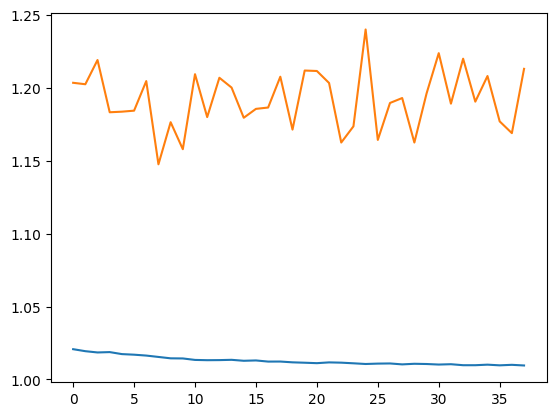

In [ ]:
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.show()

In [ ]:
test_pred = mlpclassifier.predict(test_X)
test_results = np.argmax(test_pred, axis=-1)
test_pred.shape, test_results.shape

541/541 [==============================] - 3s 5ms/step


((17289, 3), (17289,))

In [ ]:
train_pred = mlpclassifier.predict(train_X)
train_results = np.argmax(train_pred, axis=-1)
train_pred.shape, train_results.shape

2638/2638 [==============================] - 13s 5ms/step


((84406, 3), (84406,))

In [ ]:
from sklearn.metrics import f1_score
# evaluate
train_f1 = f1_score(train_y, train_results, average='macro')
train_f1

0.4989816638058832

In [ ]:
# 3개를 하나로!

In [ ]:
sample_submission_df = pd.read_csv("data/sample_submission.csv")

train_df.shape, test_df.shape, sample_submission_df.shape

((84406, 39), (17289, 38), (17289, 2))

In [ ]:
mname = 'mlpclassifier_keras'
desc = 'oversampled'

In [ ]:
from datetime import datetime as dt

def make_report(template, test_pred, mname):
    template['TARGET'] = test_pred
    now = dt.strftime(dt.now(), '%y-%m-%d')
    template.to_csv(f'results/{mname}-{desc}-{now}.csv', index=False)
    
make_report(sample_submission_df, test_results, mname)

In [ ]:
## optimizer
## early stopping
## compile
## train
## evaluate

????